In [2]:
import numpy as np
import random
import sklearn
from sklearn import metrics, ensemble, preprocessing
from matplotlib import pyplot as plt
from scipy.stats import norm
import os
import datetime

np.set_printoptions(suppress=True)
np.random.seed(100)
random.seed(100)

In [3]:
import tensorflow as tf
from tensorflow import keras

os.environ['TF_XLA_FLAGS'] = '--tf_xla_enable_xla_devices'

print(tf.__version__)
print("GPU available:", len(tf.config.list_physical_devices('GPU')))

gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_visible_devices(gpus[1], 'GPU')

# tf.compat.v1.disable_eager_execution()
tf.config.run_functions_eagerly(True)

2023-04-29 01:01:46.811878: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


2.4.1
GPU available: 8


2023-04-29 01:01:47.835702: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2023-04-29 01:01:47.975003: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-29 01:01:47.976859: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:05:00.0 name: Tesla V100-SXM3-32GB computeCapability: 7.0
coreClock: 1.597GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 913.62GiB/s
2023-04-29 01:01:47.977063: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-29 01:01:47.978730: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 1 with properties: 
pciBusID: 0000

In [4]:
PROJECT_PATH = '/raid/shumnov/music-style-performer/'

In [5]:
NOTES_QTY = 16
NOTE_PARAMS = 3
TEST_LEN = 10000

In [6]:
def prepare(dset):
    res = np.delete(dset, (1, 2), axis=2)
    
    tmp = res[..., 1].copy()
    res[..., 1] = res[..., 2]
    res[..., 2] = tmp
    
    # 0 - note
    # 1 - duration
    # 2 - velocity
    
    return res

In [7]:
def normalize_train(dset):
    notes_scaler = sklearn.preprocessing.RobustScaler()
    notes_scaler.fit(dset[..., 0])
    dset[..., 0] = notes_scaler.transform(dset[..., 0])
    
    duration_scaler = sklearn.preprocessing.MaxAbsScaler()
    duration_scaler.fit(dset[..., 1])
    dset[..., 1] = duration_scaler.transform(dset[..., 1])
    
    dset[..., 2] /= 127
    
    return (notes_scaler, duration_scaler)

def normalize_test(dset, params):
    notes_scaler, duration_scaler = params
    
    dset[..., 0] = notes_scaler.transform(dset[..., 0])
    dset[..., 1] = duration_scaler.transform(dset[..., 1])
    dset[..., 2] /= 127
    

In [8]:
def mess_n(lines, n):
    mu, std = norm.fit(lines[..., 2].flatten())
    
    for line in lines:
        idxs = random.sample(range(len(line)), n)

        for idx in idxs:
            line[idx][2] = np.random.normal(mu, std)
            
def mess(test):
    test_messed = test.copy()
    for i in range(NOTES_QTY):
        mess_n(test_messed[i * TEST_LEN: (i + 1) * TEST_LEN], i+1)
        
    return test_messed

In [9]:
dset = np.load(PROJECT_PATH + 'data/dset16.npy')
dset = dset.astype(float)

In [10]:
# unique, counts = np.unique(dset[...,3], return_counts=True)
# plt.plot(unique, counts, '.-')
# plt.show()

In [11]:
processed = prepare(dset)
np.random.shuffle(processed)

In [12]:
full_test_len = NOTES_QTY * TEST_LEN

train = processed[:-full_test_len] 
test = processed[-full_test_len:]
test_messed = mess(test)

params = normalize_train(train)
normalize_test(test, params)
normalize_test(test_messed, params)

print(f'train: {train.shape}, test: {test.shape}, messed: {test_messed.shape}')

train: (4912011, 16, 3), test: (160000, 16, 3), messed: (160000, 16, 3)


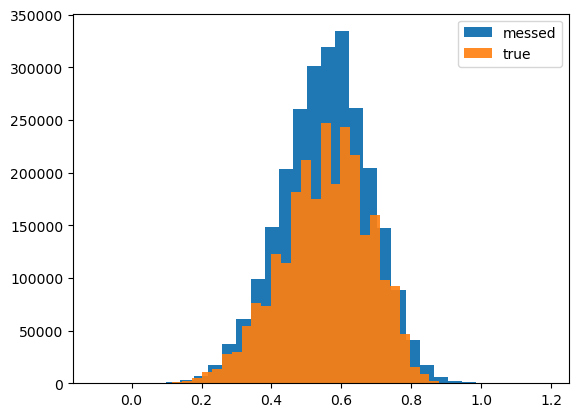

In [13]:
plt.hist(test_messed[..., 2].flatten(), bins=32, label='messed')
plt.hist(test[..., 2].flatten(), bins=32, label='true', alpha=0.9)
plt.legend()
plt.show()

# Models

In [14]:
LATENT_DIM = 32
I = 0.01 # noise

## Autoencoder

In [15]:
class LstmAutoencoder(keras.Model):
    def __init__(self):
        super(LstmAutoencoder, self).__init__()
        
        self.build_encoder()
        self.build_decoder()
        
    def build_encoder(self):        
        self.encoder = keras.Sequential([
            keras.layers.Input(shape=(NOTES_QTY, NOTE_PARAMS)),
            keras.layers.LSTM(LATENT_DIM, activation="tanh"),
        ])
        
    def build_decoder(self):
        self.decoder = keras.Sequential([
            keras.layers.RepeatVector(NOTES_QTY),
            keras.layers.LSTM(NOTE_PARAMS, return_sequences=True)
        ])

    def call(self, x, training=True):
        encoded = self.encoder(x, training=training)
        decoded = self.decoder(encoded, training=training)
        return decoded


In [16]:
class MultiLayerAutoencoder(keras.Model):
    def __init__(self):
        super(MultiLayerAutoencoder, self).__init__()
        
        self.build_encoder()
        self.build_decoder()
        
    def build_encoder(self):        
        self.encoder = keras.Sequential([
            keras.layers.Flatten(),
            
            keras.layers.Dense(NOTES_QTY * NOTE_PARAMS, activation='relu'),
            keras.layers.Dense(32, activation='relu'),
            keras.layers.Dense(LATENT_DIM, activation='tanh'),
        ])
        
    def build_decoder(self):
        self.decoder = keras.Sequential([
            keras.layers.Input(shape=(LATENT_DIM)),
            
            keras.layers.Dense(32, activation='relu'),
            keras.layers.Dense(32, activation='relu'),
            keras.layers.Dense(NOTES_QTY * NOTE_PARAMS, activation='tanh'),
            
            keras.layers.Reshape((NOTES_QTY, NOTE_PARAMS))
        ])

    def call(self, x, training=True):
        encoded = self.encoder(x, training=training)
        decoded = self.decoder(encoded, training=training)
        return decoded

In [17]:
autoencoder = MultiLayerAutoencoder()

test_out = autoencoder(train[0:1], training=False)
print(test_out.shape)

en_test_out = autoencoder.encoder(train[0:1], training=False)
print(en_test_out.shape)

de_test_out = autoencoder.decoder(en_test_out, training=False)
print(de_test_out.shape)

2023-04-29 01:02:12.606318: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-29 01:02:12.617111: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2693670000 Hz
2023-04-29 01:02:12.620628: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x2dbdce0 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2023-04-29 01:02:12.620666: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2023-04-29 01:02:12.776756: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so retu

(1, 16, 3)
(1, 32)
(1, 16, 3)


In [18]:
autoencoder_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

## Latent Discriminator

In [19]:
class LatentDisc(keras.Model):
    def __init__(self):
        super(LatentDisc, self).__init__()
        
        # self.l1 = keras.layers.Dense(128, activation='relu')(self.input)
        self.l1 = keras.layers.Dense(64, activation='relu')
        self.l2 = keras.layers.Dense(32, activation='relu')
        self.l3 = keras.layers.Dense(16, activation='relu')
        self.outp = keras.layers.Dense(1, activation='sigmoid')
        
    def call(self, x, training=True):
        x = self.l1(x)
        x = self.l2(x)
        x = self.l3(x)
        x = self.outp(x)
        return x

In [20]:
ldisc = LatentDisc()

test_out = ldisc(np.ones(shape=(1, LATENT_DIM)), training=False)
print(test_out.shape)

(1, 1)


In [21]:
ldisc_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

## Visual Discriminator
(and classifier)

In [22]:
class LstmVisualDisc(keras.Model):
    def __init__(self):
        super(LstmVisualDisc, self).__init__()
        
        self.lstm = keras.layers.LSTM(1)
        self.outp = keras.layers.Dense(1, activation='sigmoid')
        
    def call(self, x, training=True):
        x = self.lstm(x)
        x = self.outp(x)
        return x

In [23]:
class MultiLayerVisualDisc(keras.Model):
    def __init__(self):
        super(MultiLayerVisualDisc, self).__init__()
        
        self.flatten = keras.layers.Flatten()
        self.l1 = keras.layers.Dense(64, activation='relu')
        self.l2 = keras.layers.Dense(32, activation='relu')
        self.l3 = keras.layers.Dense(16, activation='relu')
        self.outp = keras.layers.Dense(1, activation='sigmoid')
        
    def call(self, x, training=True):
        x = self.flatten(x)
        x = self.l1(x)
        x = self.l2(x)
        x = self.l3(x)
        x = self.outp(x)
        return x

In [24]:
vdisc = MultiLayerVisualDisc()

test_out = vdisc(train[0:1], training=False)
print(test_out.shape)

(1, 1)


In [25]:
vdisc_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

In [26]:
classifier = MultiLayerVisualDisc()
test_out = classifier(train[0:1], training=False)
print(test_out.shape)

(1, 1)


In [27]:
classifier_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

# Helpers

In [28]:
checkpoint_dir = PROJECT_PATH + 'train_data/discriminator/checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(autoencoder_optimizer=autoencoder_optimizer,
                                ldisc_optimizer=ldisc_optimizer,
                                vdisc_optimizer=vdisc_optimizer,
                                classifier_optimizer=classifier_optimizer,
                                autoencoder=autoencoder,
                                ldisc=ldisc,
                                vdisc=vdisc,
                                classifier=classifier)

In [29]:
log_dir=PROJECT_PATH + 'train_data/discriminator/logs/'

summary_writer = tf.summary.create_file_writer(
    log_dir + "fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

In [30]:
bce = tf.keras.losses.BinaryCrossentropy(from_logits=True)
mse = tf.keras.losses.MeanSquaredError()

In [31]:
l2_optimizer = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.0)

# Prediction

In [32]:
from sklearn.metrics import mean_squared_error

In [33]:
# @tf.function
# def mse_pair(x):
#     return mse(x[0], x[1])
# 
# @tf.function
# def predict(x):
#     y = autoencoder(x)
#     
#     stacked = tf.stack([x, y], axis=1)
#     err = tf.map_fn(mse_pair, stacked)
#     
#     return err

In [97]:
@tf.function
def predict(x):
    y = autoencoder(x)
    
    err = tf.math.square(x[..., 2] - y[..., 2])
    # err = tf.math.reduce_mean(err, axis=2)
    err = tf.math.reduce_mean(err, axis=1)
    
    err = tf.math.sqrt(err)
    
    return err

In [98]:
predict(test).numpy()

array([0.08173571, 0.03815147, 0.09382783, ..., 0.07114984, 0.10290299,
       0.03796435], dtype=float32)

# Training

In [35]:
INM_ITERS = 5
LAMBDA = 2
EPOCHS = 10
BATCH_SIZE = 32

In [36]:
train_dataset = tf.data.Dataset.from_tensor_slices(train).batch(BATCH_SIZE)

In [37]:
@tf.function
def train_step(x, step):
    batch_size = x.shape[0]
    zeros = np.zeros((batch_size, 1))
    ones = np.ones((batch_size, 1))
    
    n = np.random.normal(0, I, x.shape)
    x_noisy = x + n
    
    l1 = autoencoder.encoder(x_noisy)
    l2 = tf.Variable(np.random.uniform(-1, 1, (batch_size, LATENT_DIM)))
    
    #
    # Classifier update
    #
    
    with tf.GradientTape() as gt:
        l_classifier = bce(zeros, classifier(autoencoder.decoder(l2))) \
                        + bce(ones, classifier(autoencoder.decoder(l1)))
        
    classifier_gradients = gt.gradient(l_classifier, classifier.trainable_variables)
    classifier_optimizer.apply_gradients(zip(classifier_gradients, classifier.trainable_variables)) 
    
    #
    # Discriminator update
    #
    
    with tf.GradientTape(persistent=True) as gt:
        l_latent = bce(zeros, ldisc(l1)) \
                    + bce(ones, ldisc(l2))
        
        l_visual = bce(zeros, vdisc(autoencoder.decoder(l2))) \
                    + bce(ones, vdisc(x))
        
    ldisc_gradients = gt.gradient(l_latent, ldisc.trainable_variables)
    ldisc_optimizer.apply_gradients(zip(ldisc_gradients, ldisc.trainable_variables))
    
    vdisc_gradients = gt.gradient(l_visual, vdisc.trainable_variables)
    vdisc_optimizer.apply_gradients(zip(vdisc_gradients, vdisc.trainable_variables))
    
    #
    # Informative-negative mining
    #
    
    for i in range(INM_ITERS):
        with tf.GradientTape() as gt:
            l_l2 = bce(ones, classifier(autoencoder.decoder(l2)))
        
        l2_gradients = gt.gradient(l_l2, l2)
        l2_optimizer.apply_gradients([(l2_gradients, l2)])
    
    #
    # Generator update
    #
    
    with tf.GradientTape() as gt:
        gt.watch(autoencoder.variables)
        
        l1 = autoencoder.encoder(x_noisy)
        
        l_ae_latent = bce(ones, ldisc(l1))
        l_ae_visual = bce(ones, vdisc(autoencoder.decoder(l2)))
        l_ae_mse = mse(x, autoencoder(x_noisy))
        
        total_ae_loss = l_ae_latent + l_ae_visual + LAMBDA * l_ae_mse
        
    ae_gradients = gt.gradient(total_ae_loss, autoencoder.variables)
    autoencoder_optimizer.apply_gradients(zip(ae_gradients, autoencoder.variables))
      
    #
    # Logging 
    #
    
    with summary_writer.as_default():
        tf.summary.scalar('l_classifier', l_classifier, step=step)
        tf.summary.scalar('l_latent', l_latent, step=step)
        tf.summary.scalar('l_visual', l_visual, step=step)
        tf.summary.scalar('l_ae_mse', l_ae_mse, step=step)
        tf.summary.scalar('l_ae_latent', l_ae_latent, step=step)
        tf.summary.scalar('l_ae_visual', l_ae_visual, step=step)
        tf.summary.scalar('l_ae_total', total_ae_loss, step=step)
 

In [38]:
# %reload_ext tensorboard
# %tensorboard --logdir {log_dir} --host "0.0.0.0"

In [44]:
checkpoint.restore(checkpoint_dir + '/ckpt-1')

In [40]:
@tf.function
def fit(start, epochs):
    step = 0
    for epoch in range(start, start + epochs):
        for batch in train_dataset:
            train_step(batch, tf.cast(step, tf.int64))
            
            if (step+1) % 1000 == 0:
                print('.', end='', flush=True)
                
            step += 1
                
        checkpoint.save(file_prefix=checkpoint_prefix)

In [ ]:
fit(0, 10)

.

# Validate

In [99]:
true_predict = predict(test).numpy()
messed_predict = predict(test_messed).numpy()

groups = [(true_predict[i:i+TEST_LEN], messed_predict[i:i+TEST_LEN]) for i in range(0, len(test), TEST_LEN)]

In [161]:
def show(groups):
    x = list(range(1, NOTES_QTY + 1))
    y_mean = []
    y_var = []
    
    diffs = []

    for i in range(NOTES_QTY):
        diff = groups[i][1] - groups[i][0]
        diffs.append(diff)

        m = np.mean(diff)
        var = np.std(diff) / m

        y_mean.append(m)
        y_var.append(var)

    fig, axs = plt.subplots(3, 2, figsize=(10, 10))
    
    axs[0][0].title.set_text('Diff - Average')
    axs[0][0].plot(x, y_mean, 'o-')
    
    axs[0][1].title.set_text('Diff - Coefficient of variation')
    axs[0][1].plot(x, y_var, 'o-')
    
    axs[1][0].title.set_text('Diff 1-2')
    for i in range(0, 2):
        axs[1][0].hist(diffs[i], bins=30, label=str(i + 1), alpha=0.5)
    axs[1][0].legend()
    
    axs[1][1].title.set_text('Diff 3-4')
    for i in range(2, 4):
        axs[1][1].hist(diffs[i], bins=30, label=str(i + 1), alpha=0.5)
    axs[1][1].legend()
    
    axs[2][0].title.set_text('Diff 8-9')
    for i in range(7, 9):
        axs[2][0].hist(diffs[i], bins=30, label=str(i + 1), alpha=0.5)
    axs[2][0].legend()
    
    axs[2][1].title.set_text('Diff 15-16')
    for i in range(14, 16):
        axs[2][1].hist(diffs[i], bins=30, label=str(i + 1), alpha=0.5)
    axs[2][1].legend()
    
    plt.subplots_adjust(hspace=0.3)
    plt.show()

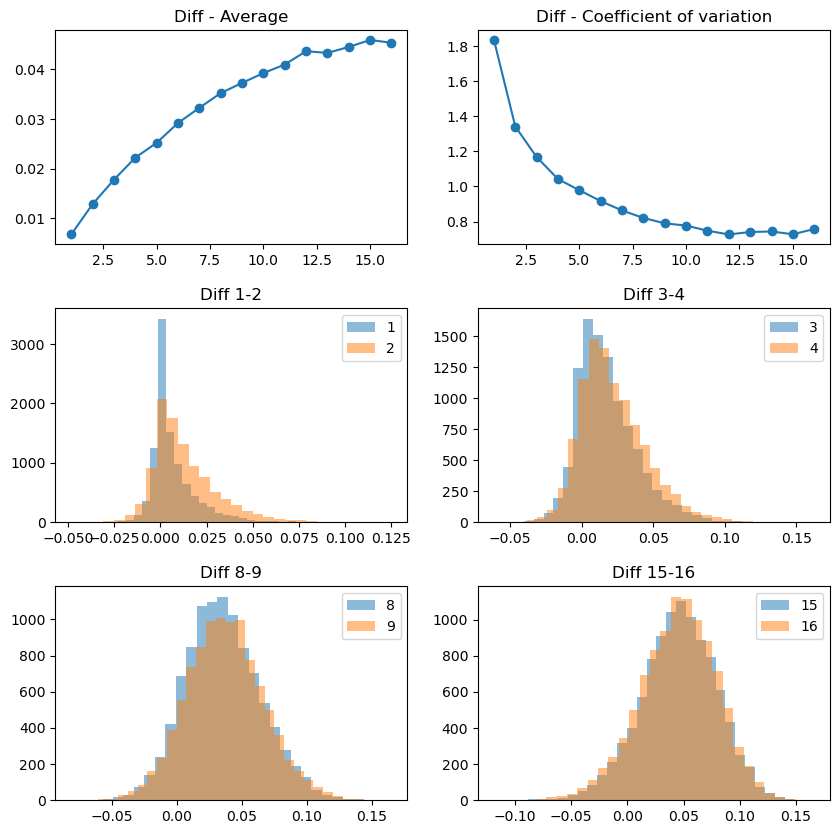

In [162]:
show(groups)

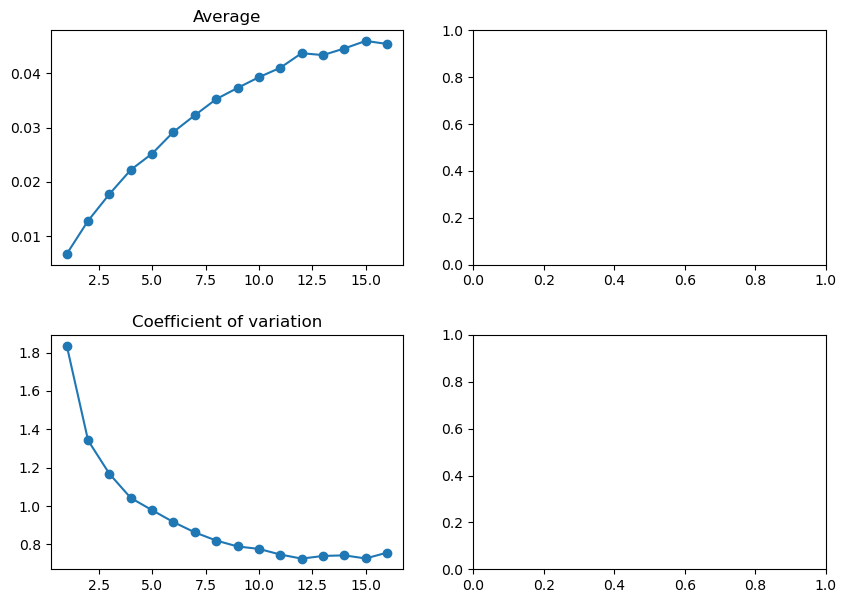

In [116]:
show(groups)

In [ ]:
plt.hist()